In [16]:
import cv2
import numpy as np

def build_tissue_mask(full_image):
    hsv = cv2.cvtColor(full_image, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)

    sat_mask = cv2.inRange(S, 15, 255)
    not_too_bright = cv2.inRange(V, 0, 250)

    mask = cv2.bitwise_and(sat_mask, not_too_bright)

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, iterations=2)

    return mask


In [17]:
def apply_mask(image, mask):
    masked = cv2.bitwise_and(image, image, mask=mask)
    return masked


In [18]:
def gaussian_psf(size=21, sigma=3):
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    psf = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    psf /= np.sum(psf)
    return psf


In [19]:
def wiener_deconvolution(img, psf, K):
    img = img.astype(np.float32) / 255.0

    # Pad PSF to image size
    psf_padded = np.zeros_like(img)
    kh, kw = psf.shape
    psf_padded[:kh, :kw] = psf

    # FFTs
    IMG = np.fft.fft2(img)
    PSF = np.fft.fft2(psf_padded)

    PSF_conj = np.conj(PSF)
    denom = (np.abs(PSF)**2 + K)

    result = PSF_conj / denom * IMG
    result = np.fft.ifft2(result)
    result = np.abs(result)

    result = np.clip(result * 255, 0, 255).astype(np.uint8)
    return result


In [21]:
import matplotlib.pyplot as plt

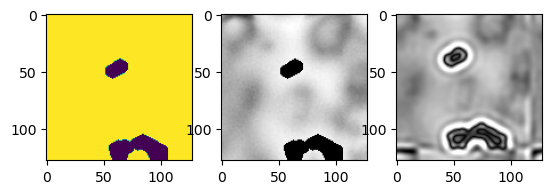

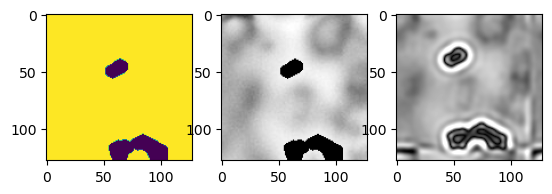

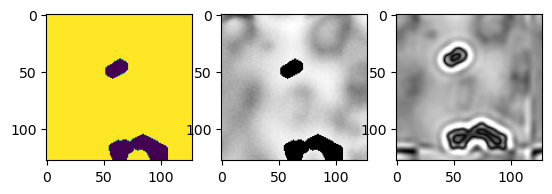

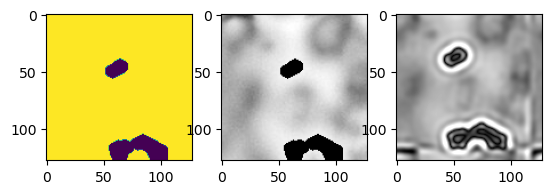

In [26]:
# Load image
img = cv2.imread(r"C:\Users\3kp05\Downloads\patch_00086.png")
import matplotlib.pyplot as plt
# Tissue mask
mask = build_tissue_mask(img)
tissue_only = apply_mask(img, mask)

# Convert to grayscale (Wiener usually works on single channel)
gray = cv2.cvtColor(tissue_only, cv2.COLOR_BGR2GRAY)

# Gaussian PSF
psf = gaussian_psf(size=21, sigma=3)

import numpy as np

K_values = np.arange(0.03, 0.0401, 0.0005)

results = {}

for K in K_values[0:4]:
    deblurred = wiener_deconvolution(gray, psf, K)
    results[K] = deblurred
    cv2.imwrite(f"deblur_K_{K}.png", deblurred)
    plt.subplot(1,3,1)
    plt.imshow(mask)
    plt.subplot(1,3,2)
    plt.imshow(gray,'gray')
    plt.subplot(1,3,3)
    plt.imshow(deblurred,'gray')
    plt.show()
